# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:
* Helping visually impaired users locate books by title/author;
* Automating inventory management (e.g., detecting misplaced or out-of-stock books);
* Enabling faster book retrieval by recognizing spine text or cover designs.

## Task
Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:
1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output
```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify;
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.

### Image Preprocessing Functions

Below are the main preprocessing steps, each to be implemented as a function:

1. **Read Images**
   - Function to load all model and scene images from their respective folders.

2. **Convert to Grayscale**
   - Function to convert an image to grayscale.

3. **Resize Images (Optional)**
   - Function to resize images to a standard size if needed.

4. **Histogram Equalization (Optional)**
   - Function to apply histogram equalization for contrast enhancement.

5. **Noise Reduction (Optional)**
   - Function to apply Gaussian blur or median filtering to reduce noise.

6. **Save/Return Preprocessed Images**
   - Function to store or return the preprocessed images for further processing.

Each function should be modular and reusable for both model and scene images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

ModuleNotFoundError: No module named 'google'

In [2]:
# 1. Read Images
import os
import cv2

def load_images_from_folder(folder_path, valid_exts={'.jpg', '.jpeg', '.png'}):
    images = {}
    for filename in os.listdir(folder_path):
        ext = os.path.splitext(filename)[1].lower()
        if ext in valid_exts:
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                images[filename] = img
    return images

# Example usage:
# models = load_images_from_folder('dataset/models')
# scenes = load_images_from_folder('dataset/scenes')

In [6]:
# 2. Convert to Grayscale

def convert_to_grayscale(image):
    """Convert a BGR image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Example usage:
# gray_img = convert_to_grayscale(models['model_0.png'])

In [4]:
# 3. Resize Images (Optional)

def resize_image(image, size):
    """Resize image to the given size (width, height)."""
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

# Example usage:
# resized_img = resize_image(gray_img, (256, 256))

In [7]:
# 4. Histogram Equalization (Optional)

def equalize_histogram(image):
    """Apply histogram equalization to a grayscale image."""
    return cv2.equalizeHist(image)

# Example usage:
# eq_img = equalize_histogram(gray_img)

### Feature Extraction Steps

1. **Choose a Feature Extraction Method**
   - Use a robust method such as SIFT or ORB.
2. **Initialize the Feature Extractor**
   - Create an instance of the chosen extractor.
3. **Extract Features from Model Images**
   - For each model image, detect keypoints and compute descriptors.
4. **Extract Features from Scene Images**
   - For each scene image, detect keypoints and compute descriptors.
5. **Store Features**
   - Organize and store keypoints and descriptors for later matching.
6. **(Optional) Visualize Keypoints**
   - Draw and display keypoints on sample images to verify extraction quality.

In [8]:
# Feature Extraction Functions using ORB (can switch to SIFT if available)
import cv2

def extract_features(images_dict, method='ORB', nfeatures=500):
    """
    Extract keypoints and descriptors from a dictionary of images.
    Args:
        images_dict: dict of {filename: image}
        method: 'ORB' or 'SIFT'
        nfeatures: number of features to extract (for ORB)
    Returns:
        dict of {filename: (keypoints, descriptors)}
    """
    features = {}
    if method.upper() == 'SIFT':
        extractor = cv2.SIFT_create()
    else:
        extractor = cv2.ORB_create(nfeatures=nfeatures)
    for fname, img in images_dict.items():
        keypoints, descriptors = extractor.detectAndCompute(img, None)
        features[fname] = (keypoints, descriptors)
    return features

# Example usage:
# model_features = extract_features(processed_models, method='ORB')
# scene_features = extract_features(processed_scenes, method='ORB')

### Book Detection in Scenes: Step-by-Step

1. **Choose a Feature Matching Method**
   - Use a matcher such as BFMatcher or FLANN for descriptor matching.
2. **Match Features Between Model and Scene**
   - For each model, match its descriptors to those in each scene image.
3. **Filter Good Matches**
   - Apply Lowe's ratio test or distance threshold to retain only good matches.
4. **Find Homography (if enough matches)**
   - Use RANSAC to estimate the homography between the model and scene.
5. **Detect Book Instances**
   - Use the homography to locate the model in the scene and compute the bounding box corners.
6. **Repeat for All Models and Scenes**
   - Detect all instances of each book in all scene images.
7. **(Optional) Visualize Matches and Detections**
   - Draw matches and detected bounding boxes for verification.

In [9]:
# Book Detection in Scenes Functions
import numpy as np
import cv2

def match_features(desc1, desc2, method='ORB', ratio=0.75):
    """
    Match descriptors between two images using BFMatcher and apply Lowe's ratio test.
    Args:
        desc1: descriptors from model image
        desc2: descriptors from scene image
        method: 'ORB' or 'SIFT'
        ratio: Lowe's ratio for filtering good matches
    Returns:
        List of good matches
    """
    if method.upper() == 'SIFT':
        matcher = cv2.BFMatcher(cv2.NORM_L2)
    else:
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = matcher.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

def find_homography_and_bbox(kp1, kp2, matches, model_shape, min_matches=10):
    """
    Find homography and bounding box corners in the scene image.
    Args:
        kp1: keypoints from model image
        kp2: keypoints from scene image
        matches: list of good matches
        model_shape: (height, width) of model image
        min_matches: minimum number of matches to compute homography
    Returns:
        bbox_corners: np.array of shape (4,2) with scene coordinates, or None if not found
        mask: mask of inliers from RANSAC
    """
    if len(matches) >= min_matches:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if H is not None:
            h, w = model_shape
            corners = np.float32([[0,0], [w,0], [w,h], [0,h]]).reshape(-1,1,2)
            bbox = cv2.perspectiveTransform(corners, H)
            return bbox.reshape(4,2), mask
    return None, None

# Example usage:
# good_matches = match_features(model_desc, scene_desc, method='ORB')
# bbox, mask = find_homography_and_bbox(model_kp, scene_kp, good_matches, model_img.shape[:2])

## Evaluation criteria
1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.

### Bounding Box Computation, Instance Counting, Area Calculation, Visualization, and Reporting: Step-by-Step

1. **Bounding Box Computation**
   - Use the homography result to compute the four corners of the detected book in the scene image.
2. **Instance Counting and Area Calculation**
   - For each detected instance, count the number of bounding boxes and calculate the area (in pixels) of each box.
3. **Visualization**
   - Draw the bounding boxes on the scene images to visualize detections.
4. **Reporting**
   - For each book, report:
     - Number of instances found
     - Area and position (four corners) of each bounding box
     - Overlay images with bounding boxes

In [10]:
# Bounding Box, Counting, Area, Visualization, and Reporting Functions
import cv2
import numpy as np

def compute_bbox_area(bbox):
    """
    Compute the area of a quadrilateral bounding box using the Shoelace formula.
    Args:
        bbox: np.array of shape (4,2) with four corners
    Returns:
        Area in pixels (float)
    """
    x = bbox[:,0]
    y = bbox[:,1]
    return 0.5 * np.abs(np.dot(x, np.roll(y,1)) - np.dot(y, np.roll(x,1)))

def draw_bounding_box(image, bbox, color=(0,255,0), thickness=2):
    """
    Draw a quadrilateral bounding box on the image.
    Args:
        image: input image (will be copied)
        bbox: np.array of shape (4,2)
        color: box color (B,G,R)
        thickness: line thickness
    Returns:
        Image with bounding box drawn
    """
    img = image.copy()
    pts = bbox.astype(int).reshape((-1,1,2))
    cv2.polylines(img, [pts], isClosed=True, color=color, thickness=thickness)
    return img

def report_detections(book_name, bboxes, areas):
    """
    Print a formatted report for detected instances of a book.
    Args:
        book_name: string
        bboxes: list of np.array (4,2)
        areas: list of float
    """
    print(f"{book_name} - {len(bboxes)} instance(s) found:")
    for i, (bbox, area) in enumerate(zip(bboxes, areas), 1):
        corners = {f"corner_{j+1}": tuple(map(int, pt)) for j, pt in enumerate(bbox)}
        print(f"  Instance {i} {{corners: {corners}, area: {int(area)}px}}")

# Example usage:
# area = compute_bbox_area(bbox)
# img_with_box = draw_bounding_box(scene_img, bbox)
# report_detections('Book 0', [bbox], [area])

Test



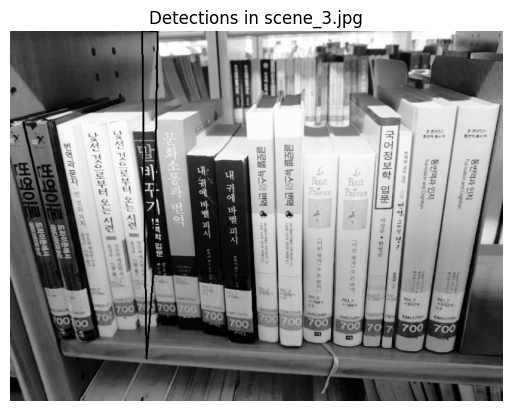

In [17]:
import matplotlib.pyplot as plt
# --------------------------------
# PIPE LINE EXECUTION
# --------------------------------

# load images to dictionaries
model_images = load_images_from_folder('./dataset/models')
scene_images = load_images_from_folder('./dataset/scenes')

# Preprocess images: grayscale, resize, histogram equalization
for key in model_images:
    gray = convert_to_grayscale(model_images[key])
    resized = resize_image(gray, (300, 400))  # Resize to a standard size
    equalized = equalize_histogram(resized)
    model_images[key] = equalized

for key in scene_images:
    gray = convert_to_grayscale(scene_images[key])
    resized = resize_image(gray, (800, 600))  # Resize to a standard size
    equalized = equalize_histogram(resized)
    scene_images[key] = equalized

# extract features from models and scenes
model_features = extract_features(model_images, method='ORB', nfeatures=200)
scene_features = extract_features(scene_images, method='ORB', nfeatures=200)

scene_with_bbox = {}

# match features
for scene_key in scene_features:
    scene_kp, scene_desc = scene_features[scene_key]
    for model_key in model_features:
        model_kp, model_desc = model_features[model_key]
        good_matches = match_features(model_desc, scene_desc, method='ORB')
        bbox, mask = find_homography_and_bbox(model_kp, scene_kp, good_matches, model_images[model_key].shape[:2])
        A_bbox = compute_bbox_area(bbox) if bbox is not None else 0
        if bbox is not None and A_bbox > 1000:  # Threshold area to filter noise
            if scene_key not in scene_with_bbox:
                scene_with_bbox[scene_key] = []
            scene_with_bbox[scene_key].append((model_key, bbox, A_bbox))

# Example: visualize the first detected bounding box on the first scene image
scene_key = list(scene_with_bbox.keys())[0]
scene_img = scene_images[scene_key].copy()

for model_key, bbox, area in scene_with_bbox[scene_key]:
    scene_img = draw_bounding_box(scene_img, bbox)

plt.imshow(scene_img, cmap="gray", vmin=0, vmax=255)
plt.title(f"Detections in {scene_key}")
plt.axis("off")
plt.show()
